In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted
from mapie.classification import MapieClassifier
from util.ranking_datasets import DyadOneHotPairDataset
from models.ranking_models import DyadRankingModel, SortLayer
from torch.utils.data import DataLoader
from scipy.stats import kendalltau
from sklearn.datasets import make_classification
from mapie.conformity_scores import LACConformityScore, APSConformityScore, TopKConformityScore
import torch

class MultinomialSyntheticDataGenerator(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=None):
        """
        A custom estimator for generating synthetic data using multinomial logistic regression,
        with the feature distribution inferred from the training data.
        
        Parameters:
        - n_samples (int): Number of synthetic samples to generate.
        - random_state (int): Seed for reproducibility.
        """
        self.random_state = random_state
        np.random.seed(self.random_state)


    def fit(self, X, y):
        """
        Fits a multinomial logistic regression model to the data and estimates the feature distribution.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        - y (ndarray): Target labels of shape (n_samples,).
        
        Returns:
        - self: The fitted instance.
        """
        # Store mean and covariance of features
        self.classes_ = np.unique(y)
        self.feature_mean_ = np.mean(X, axis=0)
        self.feature_cov_ = np.cov(X, rowvar=False)
        
        # Fit a logistic regression model
        self.model_ = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=self.random_state)
        self.model_.fit(X, y)
        
        # Store the number of classes and features
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        
        return self

    def predict_proba(self, X):
        """
        Predicts class probabilities for the given feature matrix.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        
        Returns:
        - probabilities (ndarray): Predicted probabilities of shape (n_samples, n_classes).
        """
        check_is_fitted(self, "model_")
        return self.model_.predict_proba(X)
    

    def predict(self, X):
        """
        Predicts class probabilities for the given feature matrix.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        
        Returns:
        - probabilities (ndarray): Predicted probabilities of shape (n_samples, n_classes).
        """
        check_is_fitted(self, "model_")
        return self.model_.predict(X)

    def generate(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """
        check_is_fitted(self, ["model_", "feature_mean_", "feature_cov_"])
        
        # Generate synthetic features based on the inferred distribution
        X_synthetic = np.random.multivariate_normal(self.feature_mean_, self.feature_cov_, n)
        
        # Compute class probabilities
        P_Y_given_X = self.predict_proba(X_synthetic)
        
        # Sample synthetic labels
        y_synthetic = np.array([np.random.choice(self.n_classes_, p=probs) for probs in P_Y_given_X])
        
        return X_synthetic, y_synthetic


    def generate_instances(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """
        check_is_fitted(self, ["model_", "feature_mean_", "feature_cov_"])
        
        # Generate synthetic features based on the inferred distribution
        
        X = np.random.multivariate_normal(self.feature_mean_, self.feature_cov_, n)
        return X



In [2]:
class OracleAnnotator:
    def __init__(self,mapie_clf, generator):
        self.mapie_clf = mapie_clf
        self.classes_ = mapie_clf.classes_
        self.generator = generator

    def generate_pairs_in_instance(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """        
        # Generate synthetic features based on the inferred distribution
        X = self.generator.generate_instances(n)
        X = np.repeat(X, repeats=2, axis=0)

        y = np.hstack([np.random.choice(self.classes_, size=2, replace=False) for _ in range(n)])

        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)
        return X_pairs, y_pairs


    def generate_pairs_cross_instance(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """        
        # Generate synthetic features based on the inferred distribution
        
        X = self.generator.generate_instances(2*n)
        y = np.random.choice(self.classes_, size=2*n, replace=True)
        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)

        return X_pairs, y_pairs
    
    def create_pairs_for_classification_data(self, X):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """
        # Generate synthetic features based on the inferred distribution
        
        X = self.generator.generate_instances(2*n)
        y = np.random.choice(self.classes_, size=2*n, replace=True)
        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)

        return X_pairs, y_pairs

    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.mapie_clf.estimator.predict_proba(X)
        scores = self.mapie_clf.conformity_score_function_.get_conformity_scores(
                        y, y_pred_proba, y_enc=y
                    )
        return scores

In [3]:
# from venv import create
# from util.ranking_datasets import DyadOneHotPairDataset
# from mapie.classification import MapieClassifier
# from mapie.conformity_scores.sets import APSConformityScore, LACConformityScore, NaiveConformityScore, TopKConformityScore
# from torch.utils.data.dataloader import DataLoader
# from sklearn.datasets import make_classification
# from scipy.stats import kendalltau
# import matplotlib.pyplot as plt

# def create_dyads(X,y, n_classes):
#     y_1h = np.eye(n_classes)[y.reshape(-1)].reshape(*y.shape, n_classes)
#     dyads = np.concatenate((X, y_1h.squeeze()), axis=1)
#     return dyads

# X_seed, y_seed = make_classification(n_samples=1000, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42)
# conformity_score = APSConformityScore()
# generator = MultinomialSyntheticDataGenerator(random_state=42)
# generator.fit(X_seed, y_seed)
# X_cal, y_cal = generator.generate(n=100)
# mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=conformity_score)
# # create mapie classifier for conformity scores
# mapie_clf.fit(X_cal, y_cal)
# # create 
# oracle_annotator = OracleAnnotator(mapie_clf, generator)

# # generate all possible pairs for a couple of instances

# def create_training_data(n_instances):
#     n_classes = len(generator.classes_)
#     X_train = generator.generate_instances(n_instances).repeat(n_classes, axis=0)
#     y_train = np.tile(generator.classes_, n_instances)
#     conformities = oracle_annotator.get_conformity(X_train,y_train)
#     sort_idx = (-conformities).argsort(axis=0).flatten()

#     X_sorted = X_train[sort_idx]
#     y_sorted = y_train[sort_idx]

#     X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
#     y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
#     y_pairs = np.expand_dims(y_pairs, axis=-1)
#     y_pairs_1h = np.eye(n_classes)[y_pairs.reshape(-1)].reshape(*y_pairs.shape, n_classes)
#     dyads = np.concatenate((X_pairs, y_pairs_1h.squeeze()), axis=2)
#     ds_1h = DyadOneHotPairDataset()
#     ds_1h.create_from_numpy_dyad_pairs(dyads)
#     return ds_1h, X_train, y_train

# from models.ranking_models import DyadRankingModel, SortLayer
# import torch

# model = DyadRankingModel(input_dim=6,hidden_dims=[6,6,6],activations=[torch.nn.Sigmoid(), SortLayer(), torch.nn.Identity()])


# train_data, X_train, y_train = create_training_data(100)
# val_data, X_val, y_val = create_training_data(50)

# train_loader = DataLoader(train_data, 64)
# val_loader = DataLoader(val_data, 64)


# model._fit(train_loader,val_loader=val_loader, num_epochs=200, patience=1000, learning_rate=0.01, verbose=True)

# def create_dyads(X,y, n_classes):
#     y_1h = np.eye(n_classes)[y.reshape(-1)].reshape(*y.shape, n_classes)
#     dyads = np.concatenate((X, y_1h.squeeze()), axis=1)
#     return dyads

# X_test, y_test = generator.generate(10)

# conformities = oracle_annotator.get_conformity(X_test, y_test)

# dyads_test= create_dyads(X_test, y_test, 3)
# dyads_tensor = torch.tensor(dyads_test, dtype=torch.float32)
# skills = model(dyads_tensor).detach().cpu().numpy()
# print("out of sample", kendalltau(skills, conformities))

# X_test, y_test = X_train, y_train

# conformities = oracle_annotator.get_conformity(X_test, y_test)

# dyads_test= create_dyads(X_test, y_test, 3)
# dyads_tensor = torch.tensor(dyads_test, dtype=torch.float32)
# skills = model(dyads_tensor).detach().cpu().numpy()
# print("in of sample", kendalltau(skills, conformities))


In [40]:
def conduct_oracle_experiment(conformity_score, num_instances_to_check, generator, X_cal, y_cal):
    tau_corrs = []
    # Generate a small dataset

    mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=conformity_score)
    # create mapie classifier for conformity scores
    mapie_clf.fit(X_cal, y_cal)
    # create 
    oracle_annotator = OracleAnnotator(mapie_clf, generator)
    models = []

    for num_instances in num_instances_to_check:

        X_train = generator.generate_instances(num_instances).repeat(3, axis=0)
        y_train = np.tile(generator.classes_, num_instances)
        conformities = oracle_annotator.get_conformity(X_train,y_train)
        sort_idx = (-conformities).argsort(axis=0).flatten()

        X_sorted = X_train[sort_idx]
        y_sorted = y_train[sort_idx]

        X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
        y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])

        y_pairs_1h = np.eye(3)[y_pairs.reshape(-1)].reshape(*y_pairs.shape, 3)
        dyads = np.concatenate((X_pairs, y_pairs_1h.squeeze()), axis=2)
        ds_1h = DyadOneHotPairDataset()
        ds_1h.create_from_numpy_dyad_pairs(dyads)
        pair_loader = DataLoader(ds_1h, batch_size=64)
        model = DyadRankingModel(input_dim=6,hidden_dims=[6,6,6],activations=[torch.nn.Sigmoid(), SortLayer(), torch.nn.ReLU()])

        model.num_classes = generator.n_classes_
        # model.to("cuda")
        device = next(model.parameters()).device
        print(f"Model is on: {device}")
        model._fit(pair_loader, val_loader=pair_loader, num_epochs=250, learning_rate=0.001, patience=100, verbose=True)

        # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
        X_test = generator.generate_instances(100).repeat(3, axis=0)
        y_test = np.tile(generator.classes_, 100)        
        skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
        conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
        tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
        tau_corrs.append(tau_corr)
        models.append(models)
        torch.cuda.empty_cache()
    return tau_corrs, skills_from_model, conformity_scores, models

In [41]:
num_pairs_to_check = np.linspace(10,100,3).astype(int)
X_train, y_train = make_classification(
    n_samples=100, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42
)

# Initialize and fit the generator
generator = MultinomialSyntheticDataGenerator(random_state=42)
generator.fit(X_train, y_train)
X_cal, y_cal = generator.generate(n=100)
tau_corrs_LAC, skills_LAC, conformities_LAC, models_LAC = conduct_oracle_experiment(LACConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)
# tau_corrs_Naive, skills_Naive, conformities_Naive = conduct_oracle_experiment(NaiveConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model is on: cpu
Epoch 1/250
  Train Loss: 0.0993
  Val Loss: 0.0993
Epoch 2/250
  Train Loss: 0.0993
  Val Loss: 0.0992
Epoch 3/250
  Train Loss: 0.0992
  Val Loss: 0.0992
Epoch 4/250
  Train Loss: 0.0992
  Val Loss: 0.0992
Epoch 5/250
  Train Loss: 0.0992
  Val Loss: 0.0992
Epoch 6/250
  Train Loss: 0.0992
  Val Loss: 0.0992
Epoch 7/250
  Train Loss: 0.0992
  Val Loss: 0.0992
Epoch 8/250
  Train Loss: 0.0992
  Val Loss: 0.0992
Epoch 9/250
  Train Loss: 0.0992
  Val Loss: 0.0992
Epoch 10/250
  Train Loss: 0.0992
  Val Loss: 0.0992
Epoch 11/250
  Train Loss: 0.0992
  Val Loss: 0.0991
Epoch 12/250
  Train Loss: 0.0991
  Val Loss: 0.0991
Epoch 13/250
  Train Loss: 0.0991
  Val Loss: 0.0991
Epoch 14/250
  Train Loss: 0.0991
  Val Loss: 0.0991
Epoch 15/250
  Train Loss: 0.0991
  Val Loss: 0.0991
Epoch 16/250
  Train Loss: 0.0991
  Val Loss: 0.0991
Epoch 17/250
  Train Loss: 0.0991
  Val Loss: 0.0991
Epoch 18/250
  Train Loss: 0.0991
  Val Loss: 0.0991
Epoch 19/250
  Train Loss: 0.0991
  Va

KeyboardInterrupt: 

In [38]:
tau_corrs_APS, skills_APC, conformities_APC, models_APC = conduct_oracle_experiment(APSConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)
tau_corrs_TopK, skills_TopK, conformities_TopK, models_TopK = conduct_oracle_experiment(TopKConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)


Model is on: cpu
Epoch 1/50
  Train Loss: 0.0990
  Val Loss: 0.0989
Epoch 2/50
  Train Loss: 0.0989
  Val Loss: 0.0989
Epoch 3/50
  Train Loss: 0.0989
  Val Loss: 0.0988
Epoch 4/50
  Train Loss: 0.0988
  Val Loss: 0.0988
Epoch 5/50
  Train Loss: 0.0988
  Val Loss: 0.0988
Epoch 6/50
  Train Loss: 0.0988
  Val Loss: 0.0988
Epoch 7/50
  Train Loss: 0.0988
  Val Loss: 0.0987
Epoch 8/50
  Train Loss: 0.0987
  Val Loss: 0.0987
Epoch 9/50
  Train Loss: 0.0987
  Val Loss: 0.0987
Epoch 10/50
  Train Loss: 0.0987
  Val Loss: 0.0987
Epoch 11/50
  Train Loss: 0.0987
  Val Loss: 0.0987
Epoch 12/50
  Train Loss: 0.0987
  Val Loss: 0.0987
Epoch 13/50
  Train Loss: 0.0987
  Val Loss: 0.0986
Epoch 14/50
  Train Loss: 0.0986
  Val Loss: 0.0986
Epoch 15/50
  Train Loss: 0.0986
  Val Loss: 0.0986
Epoch 16/50
  Train Loss: 0.0986
  Val Loss: 0.0986
Epoch 17/50
  Train Loss: 0.0986
  Val Loss: 0.0986
Epoch 18/50
  Train Loss: 0.0986
  Val Loss: 0.0985
Epoch 19/50
  Train Loss: 0.0985
  Val Loss: 0.0985
Epoc

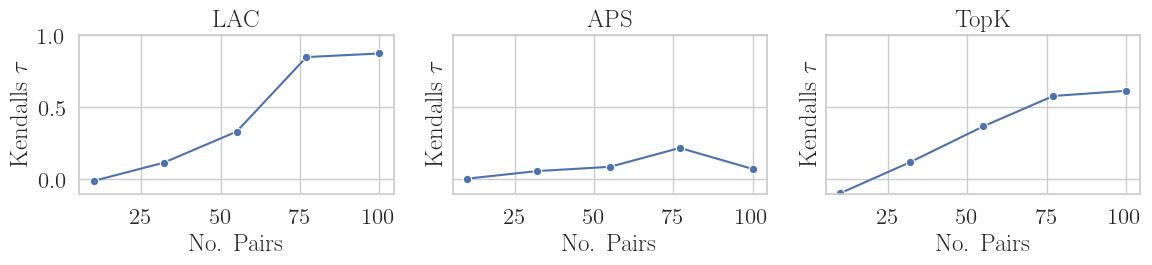

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (12, 3)



fig, axes = plt.subplots(1,3, sharey=True)
axes = axes.ravel()

axes[0].set_title("LAC")
axes[0].set_ylabel(r"Kendalls $\tau$")
axes[0].set_xlabel(r"No. Pairs")
axes[0].set_ylim([-0.1,1])
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_LAC, ax = axes[0], marker="o")
axes[1].set_title("APS")
axes[1].set_ylabel(r"Kendalls $\tau$")
axes[1].set_xlabel(r"No. Pairs")
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1], marker="o")
axes[2].set_title("TopK")
axes[2].set_ylabel(r"Kendalls $\tau$")
axes[2].set_xlabel(r"No. Pairs")
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_TopK, ax = axes[2], marker="o")
fig.tight_layout()
plt.savefig("replicating.pdf")
# axes[1].set_title("APS")
# axes[1].set_ylabel(r"Kendalls $\tau$")
# axes[1].set_xlabel(r"No. Pairs")
# sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])

ValueError: All arrays must be of the same length

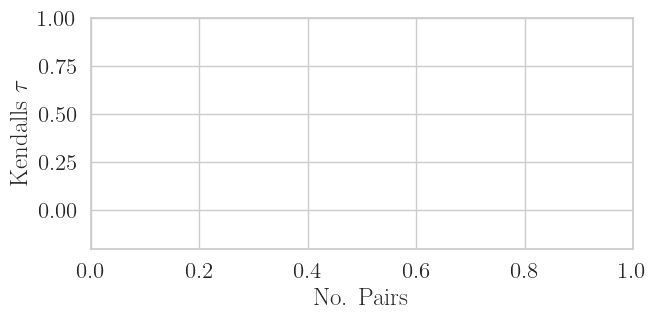

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (7, 3)



fig, ax = plt.subplots()

ax.set_title("")
ax.set_ylabel(r"Kendalls $\tau$")
ax.set_xlabel(r"No. Pairs")
ax.set_ylim([-0.2,1])
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_LAC, ax = ax, marker="o",label="LAC", legend=False)
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = ax, marker="o",label="APS", legend=False)
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_TopK, ax = ax, marker="o", label="TopK", legend=False)
lgd = fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.08), frameon=False)

fig.tight_layout() 
plt.savefig("replicating.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
# axes[1].set_title("APS")
# axes[1].set_ylabel(r"Kendalls $\tau$")
# axes[1].set_xlabel(r"No. Pairs")
# sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])